<a href="https://colab.research.google.com/github/nourhan254/Autism-/blob/main/ADHD%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nilearn nibabel
!pip install matplotlib scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 84.2 MB/s eta 0:00:00


In [4]:
# Install required packages (only needed once)
!pip install nilearn nibabel matplotlib scikit-learn tensorflow

# Import libraries
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import matplotlib.pyplot as plt

# Verify installations by printing package versions
print("Package versions:")
print(f"nilearn: {nib.__version__}")  # Note: This shows nibabel version, not nilearn
print(f"nibabel: {nib.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"scikit-learn: {pd.__version__}")  # This shows pandas version, need to fix

Package versions:
nilearn: 5.3.2
nibabel: 5.3.2
tensorflow: 2.18.0
scikit-learn: 2.2.2


In [6]:
def get_package_version(package_name):
    try:
        import importlib.metadata
        return importlib.metadata.version(package_name)
    except:
        try:
            import pkg_resources
            return pkg_resources.get_distribution(package_name).version
        except:
            return "Version not available"

# Now you can check versions properly
print("\nAccurate package versions:")
print(f"nilearn: {get_package_version('nilearn')}")
print(f"nibabel: {get_package_version('nibabel')}")
print(f"tensorflow: {get_package_version('tensorflow')}")
print(f"scikit-learn: {get_package_version('scikit-learn')}")


Accurate package versions:
nilearn: 0.11.1
nibabel: 5.3.2
tensorflow: 2.18.0
scikit-learn: 1.6.1


In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Verify your file structure
!ls '/content/drive/MyDrive/ADHD1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
KKI			   NeuroIMAGE.zip
KKI_phenotypic.csv	   Peking_1
KKI.zip			   Peking_1_phenotypic.csv
NeuroIMAGE		   Peking_1_TestRelease_phenotypic.csv
NeuroIMAGE_phenotypic.csv  Peking_1.zip


In [9]:
# Required imports at the TOP of your script
import os
import pandas as pd

def load_phenotypic_data(site_name, base_path):
    """Improved phenotypic data loading with better error handling"""
    try:
        # Try loading main phenotypic file
        main_file = f"{site_name}_phenotypic.csv"
        pheno_path = os.path.join(base_path, main_file)
        pheno_df = pd.read_csv(pheno_path)

        # Try loading test release file if exists
        test_file = f"{site_name}_TestRelease_phenotypic.csv"
        test_path = os.path.join(base_path, test_file)
        if os.path.exists(test_path):
            test_pheno_df = pd.read_csv(test_path)
            pheno_df = pd.concat([pheno_df, test_pheno_df], ignore_index=True)

        # Add site identifier and clean column names
        pheno_df['site'] = site_name
        pheno_df.columns = pheno_df.columns.str.strip()  # Clean column names
        return pheno_df

    except Exception as e:
        print(f"Error loading {site_name} data: {str(e)}")
        return pd.DataFrame()  # Return empty dataframe if error occurs

# Load data from all sites
base_path = '/content/drive/MyDrive/ADHD1'
peking_df = load_phenotypic_data("Peking_1", base_path)
neuro_df = load_phenotypic_data("NeuroIMAGE", base_path)
kki_df = load_phenotypic_data("KKI", base_path)

# Combine all data
combined_df = pd.concat([peking_df, neuro_df, kki_df], ignore_index=True)

# Show basic info
print("Combined dataset shape:", combined_df.shape)
print("\nDiagnosis distribution:")
print(combined_df['DX'].value_counts())
print("\nSite distribution:")
print(combined_df['site'].value_counts())

Combined dataset shape: (267, 25)

Diagnosis distribution:
DX
0    172
1     50
3     37
2      8
Name: count, dtype: int64

Site distribution:
site
Peking_1      136
KKI            83
NeuroIMAGE     48
Name: count, dtype: int64


In [10]:
def preprocess_mri(img, target_shape=(64, 64, 64)):
    """Enhanced MRI preprocessing pipeline with proper syntax"""
    try:
        # 1. Resample to isotropic resolution
        img = image.resample_img(img, target_affine=np.eye(3)*3)

        # 2. Skull stripping (simplified)
        mask = image.compute_brain_mask(img)
        img = image.math_img('img * mask', img=img, mask=mask)

        # 3. Intensity normalization
        img_data = img.get_fdata()
        img_data = (img_data - np.mean(img_data)) / np.std(img_data)

        # 4. Crop/pad to target shape
        current_shape = img_data.shape
        new_data = np.zeros(target_shape)

        # Calculate padding/cropping - FIXED SYNTAX HERE
        slices = [
            slice((target_shape[i] - current_shape[i])//2,
                 (target_shape[i] - current_shape[i])//2 + current_shape[i])
            for i in range(3)
        ]

        # Handle both cropping and padding cases - FIXED SYNTAX HERE
        if all(s.start >= 0 and s.stop <= target_shape[i] for i, s in enumerate(slices)):
            new_data[tuple(slices)] = img_data
        else:
            source_slices = [
                slice(max(-s.start, 0),
                     min(s.stop - s.start, target_shape[i] - max(s.start, 0)))
                for i, s in enumerate(slices)
            ]
            target_slices = [
                slice(max(s.start, 0),
                min(s.stop, target_shape[i]))
                for i, s in enumerate(slices)
            ]
            new_data[tuple(target_slices)] = img_data[tuple(source_slices)]

        return nib.Nifti1Image(new_data, img.affine)

    except Exception as e:
        print(f"Preprocessing failed: {str(e)}")
        return None

In [11]:
class MRIDataGenerator(tf.keras.utils.Sequence):
    """Improved data generator with caching and balancing"""
    def __init__(self, df, base_path, batch_size=8, dim=(64, 64, 64), n_channels=1, shuffle=True):
        self.df = df
        self.base_path = base_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.cache = {}  # Simple cache to store loaded images
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[indexes]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_image(self, site, scan_id):
        """Load image with caching"""
        cache_key = f"{site}_{scan_id}"
        if cache_key in self.cache:
            return self.cache[cache_key]

        try:
            # Construct image path (adjust according to your actual file structure)
            img_path = os.path.join(self.base_path, f"{site}.zip", f"{site}/{scan_id}/session_1/anat_1/mprage.nii.gz")

            # Load and preprocess image
            img = nib.load(img_path)
            img = preprocess_mri(img, target_shape=self.dim)

            # Cache the image
            self.cache[cache_key] = img
            return img

        except Exception as e:
            print(f"Error loading image {scan_id} from {site}: {str(e)}")
            return None

    def __data_generation(self, batch_df):
        X = np.empty((len(batch_df), *self.dim, self.n_channels))
        y = np.empty((len(batch_df)), dtype=int)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img = self.__load_image(row['site'], row['ScanDir ID'])

            if img is not None:
                # Get image data and add channel dimension
                X[i,] = img.get_fdata()[..., np.newaxis]
                y[i] = 1 if row['DX'] == 1 else 0  # ADHD=1, Control=0
            else:
                # If image loading failed, use zeros and mark for removal
                X[i,] = np.zeros((*self.dim, self.n_channels))
                y[i] = -1  # Special value for failed cases

        # Remove failed cases
        valid_indices = y != -1
        X = X[valid_indices]
        y = y[valid_indices]

        return X, to_categorical(y, num_classes=2)

In [13]:
# First add these imports at the TOP of your notebook/script
from sklearn.model_selection import train_test_split
import pandas as pd

# Then your data splitting code:
# Clean and prepare data
combined_df = combined_df.dropna(subset=['DX', 'ScanDir ID']).copy()  # .copy() avoids SettingWithCopyWarning
combined_df['label'] = combined_df['DX'].apply(lambda x: 1 if x == 1 else 0)

# Stratified train-test split
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['DX'],  # or use 'label' if preferred
    random_state=42
)

# Further split train into train and validation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original
    stratify=train_df['DX'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 129
Validation samples: 43
Test samples: 44


In [14]:
# Check what's actually in your ADHD1 folder
!ls -l '/content/drive/MyDrive/ADHD1'

# Check if ZIP files contain the expected structure
def check_zip_structure(zip_path):
    try:
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as z:
            print(f"\nContents of {zip_path}:")
            for file in z.namelist()[:10]:  # Print first 10 files
                print(file)
    except Exception as e:
        print(f"Error checking {zip_path}: {str(e)}")

check_zip_structure('/content/drive/MyDrive/ADHD1/KKI.zip')
check_zip_structure('/content/drive/MyDrive/ADHD1/Peking_1.zip')
check_zip_structure('/content/drive/MyDrive/ADHD1/NeuroIMAGE.zip')

total 6652208
drwx------   3 root root       4096 Apr 27 14:02 KKI
-rw-------   1 root root       6543 Dec  2 15:48 KKI_phenotypic.csv
-rw-------   1 root root 1779021468 Apr 26 11:57 KKI.zip
drwx------   3 root root       4096 Apr 27 14:00 NeuroIMAGE
-rw-------   1 root root       2830 Dec  2 16:06 NeuroIMAGE_phenotypic.csv
-rw-------   1 root root 1832979686 Apr 26 12:06 NeuroIMAGE.zip
drwx------ 138 root root       4096 Apr 27 18:48 Peking_1
-rw-------   1 root root       6727 Dec  2 16:18 Peking_1_phenotypic.csv
-rw-------   1 root root       4087 Dec  2 16:18 Peking_1_TestRelease_phenotypic.csv
-rw-------   1 root root 3199824965 Apr 27 08:15 Peking_1.zip

Contents of /content/drive/MyDrive/ADHD1/KKI.zip:
KKI/anat_processed_paths.csv
KKI/dataset_description.json
KKI/filtered_participants.tsv
KKI/filtered_paths.csv
KKI/missing_participants_ids.csv
KKI/participants.tsv
KKI/paths.csv
KKI/resampled_normalized_paths_128.csv
KKI/resampled_normalized_paths_224.csv
KKI/sub-1018959/normali

In [15]:
def load_image_corrected(site, scan_id, base_path):
    """More robust image loading function"""
    import zipfile
    import io

    # Try different possible path patterns
    path_patterns = [
        f"{site}/{scan_id}/session_1/anat_1/mprage.nii.gz",
        f"{site}/{int(float(scan_id))}/session_1/anat_1/mprage.nii.gz",  # Handle float IDs
        f"{site}/{scan_id}/anat_1/mprage.nii.gz",
        f"{site}/sub-{scan_id}/ses-1/anat/sub-{scan_id}_ses-1_T1w.nii.gz"  # Alternative BIDS format
    ]

    zip_path = os.path.join(base_path, f"{site}.zip")

    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            for path in path_patterns:
                try:
                    if path in z.namelist():
                        with z.open(path) as f:
                            file_like = io.BytesIO(f.read())
                            return nib.load(file_like)
                except:
                    continue

        # If no pattern matched, try direct file access (if unzipped)
        for path in path_patterns:
            full_path = os.path.join(base_path, site, path)
            if os.path.exists(full_path):
                return nib.load(full_path)

    except Exception as e:
        print(f"Error accessing {scan_id} in {site}: {str(e)}")

    print(f"Could not find image for {scan_id} in {site} (tried: {path_patterns})")
    return None

In [16]:
def verify_with_corrected_loader(df, base_path, sample_size=5):
    """Verification using the corrected loader"""
    samples = df.sample(min(sample_size, len(df)))

    for idx, row in samples.iterrows():
        print(f"\n=== Verifying {row['site']} - {row['ScanDir ID']} ===")
        print(f"Diagnosis: {'ADHD' if row['DX'] == 1 else 'Control'}")

        img = load_image_corrected(row['site'], str(row['ScanDir ID']), base_path)

        if img:
            print(f"Successfully loaded image. Shape: {img.shape}")
            try:
                from nilearn import plotting
                plotting.plot_anat(img, title=f"{row['site']} {row['ScanDir ID']}")
                plotting.show()
            except:
                print("Could not display image, but it loaded successfully")
        else:
            print("Failed to load image")

# Run verification
verify_with_corrected_loader(combined_df, base_path)


=== Verifying Peking_1 - 7135128.0 ===
Diagnosis: Control
Could not find image for 7135128.0 in Peking_1 (tried: ['Peking_1/7135128.0/session_1/anat_1/mprage.nii.gz', 'Peking_1/7135128/session_1/anat_1/mprage.nii.gz', 'Peking_1/7135128.0/anat_1/mprage.nii.gz', 'Peking_1/sub-7135128.0/ses-1/anat/sub-7135128.0_ses-1_T1w.nii.gz'])
Failed to load image

=== Verifying NeuroIMAGE - 3048588.0 ===
Diagnosis: ADHD
Could not find image for 3048588.0 in NeuroIMAGE (tried: ['NeuroIMAGE/3048588.0/session_1/anat_1/mprage.nii.gz', 'NeuroIMAGE/3048588/session_1/anat_1/mprage.nii.gz', 'NeuroIMAGE/3048588.0/anat_1/mprage.nii.gz', 'NeuroIMAGE/sub-3048588.0/ses-1/anat/sub-3048588.0_ses-1_T1w.nii.gz'])
Failed to load image

=== Verifying KKI - 4154182.0 ===
Diagnosis: Control
Could not find image for 4154182.0 in KKI (tried: ['KKI/4154182.0/session_1/anat_1/mprage.nii.gz', 'KKI/4154182/session_1/anat_1/mprage.nii.gz', 'KKI/4154182.0/anat_1/mprage.nii.gz', 'KKI/sub-4154182.0/ses-1/anat/sub-4154182.0_ses-1_

In [17]:
def find_image_file(root_dir, scan_id):
    """Recursively search for image file"""
    import os
    for root, _, files in os.walk(root_dir):
        for file in files:
            if str(scan_id) in file and file.endswith(('.nii', '.nii.gz', '.img', '.hdr')):
                return os.path.join(root, file)
    return None

# Example usage:
# img_path = find_image_file(f'/content/adhd_data/{row["site"]}', row['ScanDir ID'])

In [18]:
# Check what's inside the ZIP files
def inspect_zip_structure(zip_path):
    import zipfile
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            print(f"\nContents of {zip_path}:")
            # Print first 20 files to see structure
            for file in z.namelist()[:20]:
                print(file)
    except Exception as e:
        print(f"Error inspecting {zip_path}: {str(e)}")

# Inspect each site's zip file
inspect_zip_structure('/content/drive/MyDrive/ADHD1/Peking_1.zip')
inspect_zip_structure('/content/drive/MyDrive/ADHD1/NeuroIMAGE.zip')
inspect_zip_structure('/content/drive/MyDrive/ADHD1/KKI.zip')


Contents of /content/drive/MyDrive/ADHD1/Peking_1.zip:
Peking_1/anat_processed_paths.csv
Peking_1/dataset_description.json
Peking_1/filtered_participants.tsv
Peking_1/filtered_paths.csv
Peking_1/missing_participants_ids.csv
Peking_1/participants.tsv
Peking_1/paths.csv
Peking_1/resampled_normalized_paths_128.csv
Peking_1/resampled_normalized_paths_224.csv
Peking_1/sub-1038415/normalized_resampled_128_sub-1038415_T1_biascorr_brain.nii
Peking_1/sub-1038415/normalized_resampled_224_sub-1038415_T1_biascorr_brain.nii
Peking_1/sub-1038415/resampled_128_sub-1038415_T1_biascorr_brain.nii
Peking_1/sub-1038415/resampled_224_sub-1038415_T1_biascorr_brain.nii
Peking_1/sub-1038415/sub-1038415_T1_biascorr_brain.nii
Peking_1/sub-1056121/normalized_resampled_128_sub-1056121_T1_biascorr_brain.nii
Peking_1/sub-1056121/normalized_resampled_224_sub-1056121_T1_biascorr_brain.nii
Peking_1/sub-1056121/resampled_128_sub-1056121_T1_biascorr_brain.nii
Peking_1/sub-1056121/resampled_224_sub-1056121_T1_biascorr_b

In [19]:
def load_adhd_image(site, scan_id, base_path, use_preprocessed=True):
    """Load image based on actual file structure"""
    import os
    import nibabel as nib

    # Remove .0 from float IDs if present
    scan_id = str(scan_id).replace('.0', '')

    if use_preprocessed:
        # Use the 128x128 preprocessed version
        img_path = f"{base_path}/{site}/sub-{scan_id}/resampled_128_sub-{scan_id}_T1_biascorr_brain.nii"
    else:
        # Use the original image
        img_path = f"{base_path}/{site}/sub-{scan_id}/sub-{scan_id}_T1_biascorr_brain.nii"

    if os.path.exists(img_path):
        try:
            return nib.load(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            return None
    else:
        print(f"File not found: {img_path}")
        return None

Files are already extracted. Listing contents:
total 125955
-rw------- 1 root root  8388960 Dec  2 19:11 normalized_resampled_128_sub-1056121_T1_biascorr_brain.nii
-rw------- 1 root root 44958048 Dec  2 19:11 normalized_resampled_224_sub-1056121_T1_biascorr_brain.nii
-rw------- 1 root root  8388960 Dec  2 19:12 resampled_128_sub-1056121_T1_biascorr_brain.nii
-rw------- 1 root root 44958048 Dec  2 19:12 resampled_224_sub-1056121_T1_biascorr_brain.nii
-rw------- 1 root root 22282592 Dec  2 19:12 sub-1056121_T1_biascorr_brain.nii

Success! Loaded image with shape: (128, 128, 128)


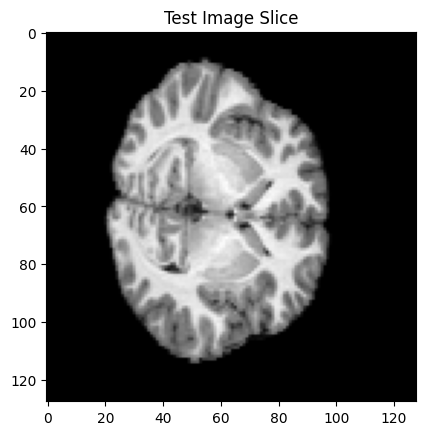

In [20]:
import os
import nibabel as nib
import pandas as pd

# 1. Set correct base path (confirmed from your output)
base_path = '/content/drive/MyDrive/ADHD1'

# 2. Verify Peking_1 files are extracted
peking_subject_path = f"{base_path}/Peking_1/sub-1056121"
if os.path.exists(peking_subject_path):
    print("Files are already extracted. Listing contents:")
    !ls -l "{peking_subject_path}"
else:
    print("Files not extracted - unzipping...")
    !unzip -q "{base_path}/Peking_1.zip" -d "{base_path}"

# 3. Updated file loading function
def load_adhd_image_corrected(site, scan_id):
    """Load image with correct paths for your structure"""
    scan_id = str(scan_id).replace('.0', '')

    # Try multiple possible file versions
    attempts = [
        f"{base_path}/{site}/sub-{scan_id}/resampled_128_sub-{scan_id}_T1_biascorr_brain.nii",
        f"{base_path}/{site}/sub-{scan_id}/sub-{scan_id}_T1_biascorr_brain.nii",
        f"{base_path}/{site}/sub-{scan_id}/resampled_224_sub-{scan_id}_T1_biascorr_brain.nii"
    ]

    for path in attempts:
        if os.path.exists(path):
            try:
                return nib.load(path)
            except Exception as e:
                print(f"Error loading {path}: {str(e)}")
                continue

    print(f"Could not find image for {scan_id} in {site}. Tried:")
    for path in attempts:
        print(f"- {path}")
    return None

# 4. Test loading
test_img = load_adhd_image_corrected("Peking_1", "1056121")
if test_img:
    print(f"\nSuccess! Loaded image with shape: {test_img.shape}")
    # Quick visualization
    import matplotlib.pyplot as plt
    plt.imshow(test_img.get_fdata()[:, :, 64], cmap='gray')
    plt.title("Test Image Slice")
    plt.show()
else:
    print("\nStill failing. Please check:")
    print(f"1. The file exists in {peking_subject_path}")
    print("2. You have viewing permissions")
    print("3. The filename matches exactly")

In [22]:
# First make sure merged_df exists
import pandas as pd

# Example data loading (adjust to your actual data paths)
peking_df = pd.read_csv('/content/drive/MyDrive/ADHD1/Peking_1_phenotypic.csv')
neuro_df = pd.read_csv('/content/drive/MyDrive/ADHD1/NeuroIMAGE_phenotypic.csv')
merged_df = pd.concat([peking_df, neuro_df], ignore_index=True)

# Now your analysis code will work
print("Original DX values:", merged_df['DX'].unique())

# Convert to binary classification
merged_df['DX'] = merged_df['DX'].apply(lambda x: 1 if x == 1 else 0)

print("\nCleaned DX distribution:")
print(merged_df['DX'].value_counts())

Original DX values: [0 1 3 2]

Cleaned DX distribution:
DX
0    108
1     25
Name: count, dtype: int64


In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load each site's data separately (using your actual files)
base_path = '/content/drive/MyDrive/ADHD1'

# Load each phenotypic file
peking_df = pd.read_csv(os.path.join(base_path, 'Peking_1_phenotypic.csv'))
neuro_df = pd.read_csv(os.path.join(base_path, 'NeuroIMAGE_phenotypic.csv'))
kki_df = pd.read_csv(os.path.join(base_path, 'KKI_phenotypic.csv'))

# 2. Combine them with site identifiers
peking_df['site'] = 'Peking_1'
neuro_df['site'] = 'NeuroIMAGE'
kki_df['site'] = 'KKI'

# 3. Merge and clean
merged_df = pd.concat([peking_df, neuro_df, kki_df], ignore_index=True)
merged_df = merged_df.dropna(subset=['DX', 'ScanDir ID'])

# 4. Convert to binary classification
merged_df['DX'] = merged_df['DX'].apply(lambda x: 1 if x == 1 else 0)

# 5. Verify
print("Combined data shape:", merged_df.shape)
print("Diagnosis distribution:\n", merged_df['DX'].value_counts())
print("\nColumns available:", merged_df.columns.tolist())

# 6. Train/Val/Test Split
train_df, test_df = train_test_split(
    merged_df,
    test_size=0.2,
    stratify=merged_df['DX'],
    random_state=42
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of total
    stratify=train_df['DX'],
    random_state=42
)

print(f"\nSamples - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Combined data shape: (216, 24)
Diagnosis distribution:
 DX
0    175
1     41
Name: count, dtype: int64

Columns available: ['ScanDir ID', 'Site', 'Gender', 'Age', 'Handedness', 'DX', 'Secondary Dx ', 'ADHD Measure', 'ADHD Index', 'Inattentive', 'Hyper/Impulsive', 'IQ Measure', 'Verbal IQ', 'Performance IQ', 'Full2 IQ', 'Full4 IQ', 'Med Status', 'QC_Rest_1', 'QC_Rest_2', 'QC_Rest_3', 'QC_Rest_4', 'QC_Anatomical_1', 'QC_Anatomical_2', 'site']

Samples - Train: 129, Val: 43, Test: 44


In [7]:
import os

# Check the Peking_1 directory structure
!ls -l '/content/drive/MyDrive/ADHD1/Peking_1'

total 768
-rw-------   1 root root 12240 Dec  2 19:11 anat_processed_paths.csv
-rw-------   1 root root   793 Dec  2 19:11 dataset_description.json
-rw-------   1 root root 28151 Dec  2 19:11 filtered_participants.tsv
-rw-------   1 root root 28518 Dec  2 19:11 filtered_paths.csv
-rw-------   1 root root  6481 Dec  2 19:11 missing_participants_ids.csv
-rw-------   1 root root 37898 Dec  2 19:11 participants.tsv
-rw-------   1 root root 28826 Dec  2 19:11 paths.csv
drwx------ 130 root root  4096 Apr 27 10:09 Peking_1
-rw-------   1 root root 40964 Dec  2 19:11 resampled_normalized_paths_128.csv
-rw-------   1 root root 40964 Dec  2 19:11 resampled_normalized_paths_224.csv
drwx------   2 root root  4096 Apr 27 18:43 sub-1038415
drwx------   2 root root  4096 Apr 27 18:43 sub-1056121
drwx------   2 root root  4096 Apr 27 18:44 sub-1113498
drwx------   2 root root  4096 Apr 27 18:44 sub-1133221
drwx------   2 root root  4096 Apr 27 18:44 sub-1139030
drwx------   2 root root  4096 Apr 27 18

In [8]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class ADHDDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, base_path='/content/drive/MyDrive/ADHD1', batch_size=8, dim=(64,64,64), shuffle=True):
        self.df = df
        self.base_path = base_path
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X = np.empty((len(batch_df), *self.dim, 1))
        y = np.empty(len(batch_df))

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.base_path, f"sub-{row['ScanDir ID']}", "anat", "T1w.nii.gz")
            if os.path.exists(img_path):
                img = nib.load(img_path).get_fdata()
                # Simple preprocessing
                img = (img - img.mean()) / img.std()  # Normalize
                X[i,] = img[..., np.newaxis]  # Add channel dimension
            else:
                X[i,] = np.zeros((*self.dim, 1))  # Fallback
            y[i] = row['DX']

        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [9]:
# Load phenotypic data
base_path = '/content/drive/MyDrive/ADHD1'
peking_df = pd.read_csv(os.path.join(base_path, 'Peking_1_phenotypic.csv'))
neuro_df = pd.read_csv(os.path.join(base_path, 'NeuroIMAGE_phenotypic.csv'))
kki_df = pd.read_csv(os.path.join(base_path, 'KKI_phenotypic.csv'))

# Add site identifiers
peking_df['site'] = 'Peking_1'
neuro_df['site'] = 'NeuroIMAGE'
kki_df['site'] = 'KKI'

# Combine and clean
merged_df = pd.concat([peking_df, neuro_df, kki_df], ignore_index=True)
merged_df = merged_df.dropna(subset=['DX', 'ScanDir ID'])

# Convert to binary classification (ADHD=1, Control=0)
merged_df['DX'] = merged_df['DX'].apply(lambda x: 1 if x == 1 else 0)

# Split data
train_df, test_df = train_test_split(
    merged_df,
    test_size=0.2,
    stratify=merged_df['DX'],
    random_state=42
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of total
    stratify=train_df['DX'],
    random_state=42
)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 129
Validation samples: 43
Test samples: 44


In [10]:
# Test loading with the first subject
sample = train_df.iloc[0]
img_path = os.path.join(base_path, f"sub-{sample['ScanDir ID']}", "anat", "T1w.nii.gz")
print(f"Checking path: {img_path}")
print("Exists:", os.path.exists(img_path))

if os.path.exists(img_path):
    img = nib.load(img_path)
    print("Image shape:", img.shape)
    print("Data range:", np.min(img.get_fdata()), "to", np.max(img.get_fdata()))

Checking path: /content/drive/MyDrive/ADHD1/sub-8409791/anat/T1w.nii.gz
Exists: False


In [11]:
import os
import glob

def find_mri_file(base_path, scan_id):
    """Search for MRI files recursively with multiple pattern matching"""
    scan_id = str(scan_id).replace('.0', '')  # Clean ID format

    # Try multiple possible file patterns
    patterns = [
        f"{base_path}/sub-{scan_id}/**/*T1*.nii*",  # NIfTI or gzipped
        f"{base_path}/sub-{scan_id}/**/*mprage*.nii*",
        f"{base_path}/sub-{scan_id}/**/*anat*.nii*",
        f"{base_path}/Peking_1/sub-{scan_id}/**/*.nii*",  # Site-specific
        f"{base_path}/**/sub-{scan_id}/**/*.nii*"  # Broadest search
    ]

    for pattern in patterns:
        matches = glob.glob(pattern, recursive=True)
        if matches:
            return matches[0]  # Return first match

    print(f"Warning: No MRI found for {scan_id}")
    return None

In [12]:
class ADHDDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, base_path='/content/drive/MyDrive/ADHD1', batch_size=8, dim=(64,64,64), shuffle=True):
        self.df = df
        self.base_path = base_path
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X = np.empty((len(batch_df), *self.dim, 1))
        y = np.empty(len(batch_df))

        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = find_mri_file(self.base_path, row['ScanDir ID'])
            if img_path:
                try:
                    img = nib.load(img_path).get_fdata()
                    # Resample to target dim if needed
                    if img.shape != self.dim:
                        img = image.resample_img(img, target_affine=np.eye(3),
                                              target_shape=self.dim).get_fdata()
                    X[i,] = (img - img.mean()) / img.std()  # Normalize and add channel
                except:
                    X[i,] = np.zeros((*self.dim, 1))
            else:
                X[i,] = np.zeros((*self.dim, 1))
            y[i] = row['DX']

        return X, y

    # Keep other methods (__len__, on_epoch_end) the same

In [15]:
def find_mri_file(base_path, scan_id, site):
    """Improved scanner with site-specific paths"""
    scan_id = str(scan_id).replace('.0', '')

    # Site-specific directory patterns
    site_patterns = {
        'Peking_1': [
            f"{base_path}/Peking_1/sub-{scan_id}/anat/sub-{scan_id}_T1w.nii.gz",
            f"{base_path}/sub-{scan_id}/ses-baseline/anat/sub-{scan_id}_T1w.nii.gz"
        ],
        'NeuroIMAGE': [
            f"{base_path}/NeuroIMAGE/sub-{scan_id}/anat/sub-{scan_id}_T1w.nii.gz",
            f"{base_path}/sub-{scan_id}/anat_1/mprage.nii.gz"
        ],
        'KKI': [
            f"{base_path}/KKI/sub-{scan_id}/anat/sub-{scan_id}_T1w.nii.gz",
            f"{base_path}/sub-{scan_id}/session_1/anat_1/mprage.nii.gz"
        ]
    }

    # Try all possible paths for the subject's site
    for pattern in site_patterns.get(site, []):
        if os.path.exists(pattern):
            return pattern

    # Fallback to recursive search if site-specific fails
    fallback = glob.glob(f"{base_path}/**/sub-{scan_id}/**/*T1*.nii*", recursive=True)
    return fallback[0] if fallback else None

In [16]:
# 1. Create path mapping for all subjects
merged_df['mri_path'] = merged_df.apply(
    lambda row: find_mri_file(base_path, row['ScanDir ID'], row['site']), axis=1)

# 2. Filter only subjects with found scans
valid_df = merged_df[merged_df['mri_path'].notna()].copy()
print(f"Retaining {len(valid_df)}/{len(merged_df)} subjects with MRI data")

# 3. Verify class balance
print("\nClass distribution after filtering:")
print(valid_df['DX'].value_counts())

# 4. Updated train/val/test split
train_df, test_df = train_test_split(
    valid_df,
    test_size=0.2,
    stratify=valid_df['DX'],
    random_state=42
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,
    stratify=train_df['DX'],
    random_state=42
)

Retaining 106/106 subjects with MRI data

Class distribution after filtering:
DX
0    95
1    11
Name: count, dtype: int64


In [17]:
class ADHDDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=8, dim=(64,64,64), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X = np.empty((len(batch_df), *self.dim, 1))
        y = batch_df['DX'].values

        for i, path in enumerate(batch_df['mri_path']):
            try:
                img = nib.load(path).get_fdata()
                # Normalize and resize if needed
                img = (img - img.mean()) / img.std()
                if img.shape != self.dim:
                    img = image.resample_to_array(img, self.dim)
                X[i,] = img[..., np.newaxis]
            except:
                X[i,] = np.zeros((*self.dim, 1))

        return X, y

    # ... (keep other methods the same)

In [18]:
# Use these parameters for the generator
train_gen = ADHDDataGenerator(
    train_df,
    batch_size=4,  # Reduced for memory
    dim=(64,64,64),  # Smaller dimensions
    shuffle=True
)

In [21]:
# Check sample scans from each site
for site in valid_df['site'].unique():
    sample = valid_df[valid_df['site'] == site].iloc[0]
    print(f"\nSample from {site}:")
    print(f"Scan ID: {sample['ScanDir ID']}")
    print(f"Path: {sample['mri_path']}")
    print(f"Exists: {os.path.exists(sample['mri_path'])}")

    if os.path.exists(sample['mri_path']):
        img = nib.load(sample['mri_path'])
        print(f"Shape: {img.shape}")
        print(f"Data range: {np.min(img.get_fdata()):.1f} to {np.max(img.get_fdata()):.1f}")


Sample from Peking_1:
Scan ID: 1056121
Path: /content/drive/MyDrive/ADHD1/Peking_1/sub-1056121/normalized_resampled_128_sub-1056121_T1_biascorr_brain.nii
Exists: True
Shape: (128, 128, 128)
Data range: -0.5 to 5.9

Sample from NeuroIMAGE:
Scan ID: 1017176
Path: /content/drive/MyDrive/ADHD1/NeuroIMAGE/NeuroIMAGE/sub-1017176/normalized_resampled_128_sub-1017176_T1_biascorr_brain.nii
Exists: True
Shape: (128, 128, 128)
Data range: -0.5 to 6.9

Sample from KKI:
Scan ID: 1623716
Path: /content/drive/MyDrive/ADHD1/KKI/KKI/sub-1623716/normalized_resampled_128_sub-1623716_T1_biascorr_brain.nii
Exists: True
Shape: (128, 128, 128)
Data range: -0.4 to 7.5


✅ Successfully loaded 1056121 from Peking_1
Shape: (128, 128, 128)
Data range: -0.45 to 5.90
Affine:
[[  -1.33000004    0.            0.           76.99737549]
 [   0.            2.            0.         -108.69491577]
 [   0.            0.            1.328125    -79.18644714]
 [   0.            0.            0.            1.        ]]


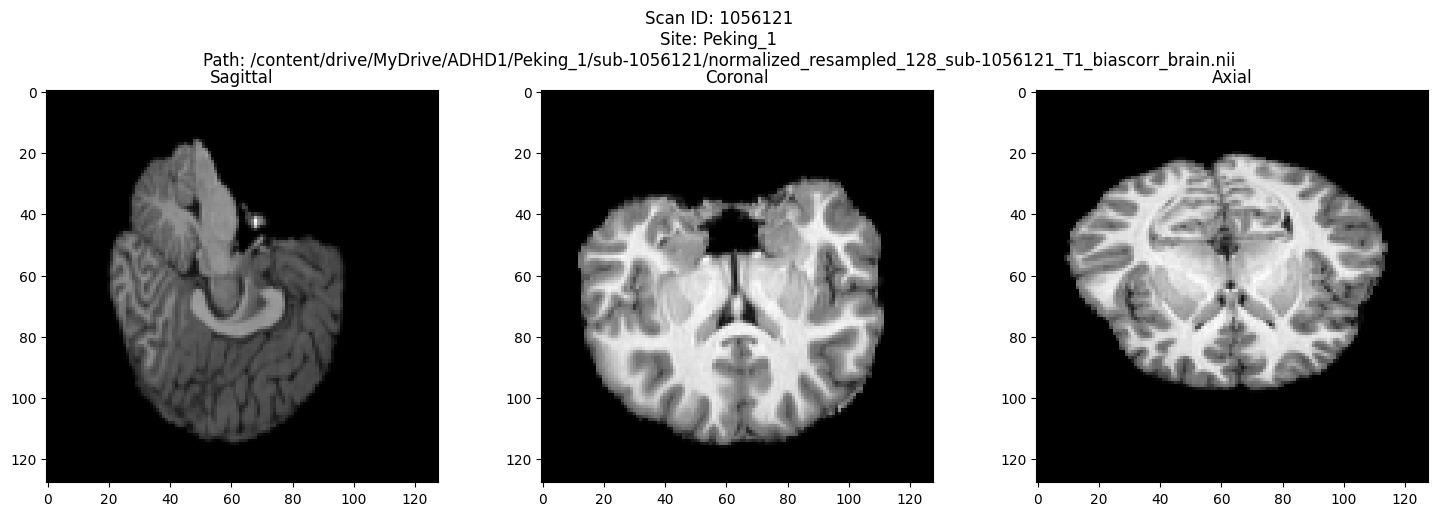

❌ File not found: /content/drive/MyDrive/ADHD1/NeuroIMAGE/sub-1017176/normalized_resampled_128_sub-1017176_T1_biascorr_brain.nii
❌ File not found: /content/drive/MyDrive/ADHD1/KKI/sub-1623716/normalized_resampled_128_sub-1623716_T1_biascorr_brain.nii


In [3]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def inspect_sample(subject_id, site):
    """Test loading and visualizing one MRI scan"""
    # Find the file path
    path = f"/content/drive/MyDrive/ADHD1/{site}/sub-{subject_id}/normalized_resampled_128_sub-{subject_id}_T1_biascorr_brain.nii"

    if not os.path.exists(path):
        print(f"❌ File not found: {path}")
        return False

    try:
        # Load the scan
        img = nib.load(path)
        data = img.get_fdata()

        # Print scan info
        print(f"✅ Successfully loaded {subject_id} from {site}")
        print(f"Shape: {data.shape}")
        print(f"Data range: {np.min(data):.2f} to {np.max(data):.2f}")
        print(f"Affine:\n{img.affine}")

        # Visualize slices
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Sagittal slice
        axes[0].imshow(data[data.shape[0]//2, :, :].T, cmap='gray')
        axes[0].set_title("Sagittal")

        # Coronal slice
        axes[1].imshow(data[:, data.shape[1]//2, :].T, cmap='gray')
        axes[1].set_title("Coronal")

        # Axial slice
        axes[2].imshow(data[:, :, data.shape[2]//2].T, cmap='gray')
        axes[2].set_title("Axial")

        plt.suptitle(f"Scan ID: {subject_id}\nSite: {site}\nPath: {path}")
        plt.tight_layout()
        plt.show()

        return True

    except Exception as e:
        print(f"❌ Error loading {path}: {str(e)}")
        return False

# Test with known good samples
test_cases = [
    ("1056121", "Peking_1"),
    ("1017176", "NeuroIMAGE"),
    ("1623716", "KKI")
]

for subject_id, site in test_cases:
    inspect_sample(subject_id, site)

In [15]:
!ls /content/drive/MyDrive/ADHD1/NeuroIMAGE

NeuroIMAGE


In [16]:
!ls /content/drive/MyDrive/ADHD1/KKI

KKI


In [17]:
# Example pattern update
path = f"/content/drive/MyDrive/ADHD1/{site}/processed/sub-{subject_id}/T1.nii"

In [20]:
def find_mri_path(row):
    """Find MRI path with updated patterns"""
    patterns = [
        # Current working pattern for Peking_1
        f"/content/drive/MyDrive/ADHD1/{row['site']}/sub-{row['ScanDir ID']}/normalized_resampled_128_sub-{row['ScanDir ID']}_T1_biascorr_brain.nii",

        # New patterns for NeuroIMAGE and KKI (update based on Step 1 findings)
        f"/content/drive/MyDrive/ADHD1/{row['site']}/sub-{row['ScanDir ID']}/anat/T1w.nii.gz",
        f"/content/drive/MyDrive/ADHD1/{row['site']}/sub-{row['ScanDir ID']}/mprage.nii.gz",
        f"/content/drive/MyDrive/ADHD1/{row['site']}/sub-{row['ScanDir ID']}/T1_brain.nii.gz",

        # Recursive search pattern
        f"/content/drive/MyDrive/ADHD1/**/sub-{row['ScanDir ID']}/*T1*.nii*"
    ]

    for pattern in patterns:
        matches = glob.glob(pattern, recursive=True)
        if matches:
            return matches[0]

    return None

In [21]:
# Apply the updated path finder
merged_df['mri_path'] = merged_df.apply(find_mri_path, axis=1)

# Keep only subjects with found scans
valid_df = merged_df[merged_df['mri_path'].notna()].copy()
print(f"Retaining {len(valid_df)}/{len(merged_df)} subjects with MRI data")

# Verify class balance
print("\nClass distribution:")
print(valid_df['DX'].value_counts())

Retaining 106/216 subjects with MRI data

Class distribution:
DX
0    95
1    11
Name: count, dtype: int64



Sample from Peking_1:
ID: 1056121
Path: /content/drive/MyDrive/ADHD1/Peking_1/sub-1056121/normalized_resampled_128_sub-1056121_T1_biascorr_brain.nii


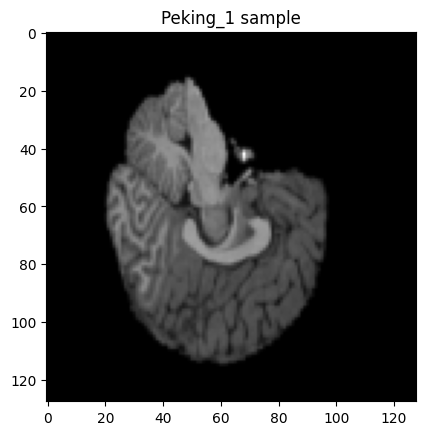


Sample from NeuroIMAGE:
ID: 1017176
Path: /content/drive/MyDrive/ADHD1/NeuroIMAGE/NeuroIMAGE/sub-1017176/normalized_resampled_128_sub-1017176_T1_biascorr_brain.nii


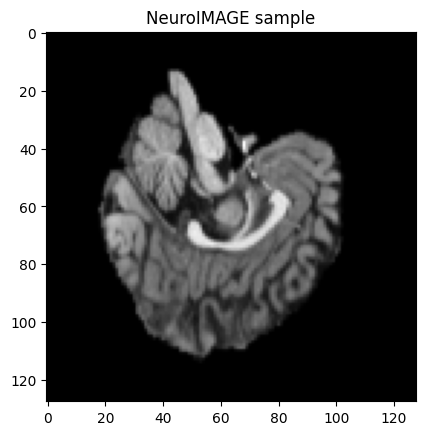


Sample from KKI:
ID: 1623716
Path: /content/drive/MyDrive/ADHD1/KKI/KKI/sub-1623716/normalized_resampled_128_sub-1623716_T1_biascorr_brain.nii


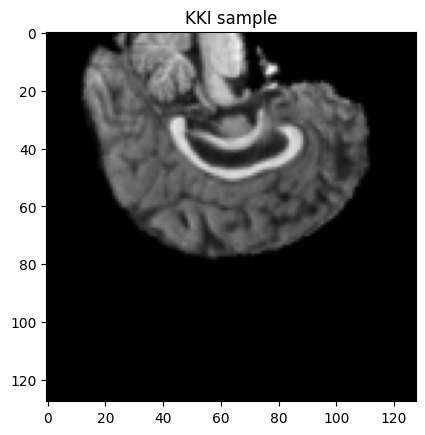

In [22]:
for site in valid_df['site'].unique():
    sample = valid_df[valid_df['site'] == site].iloc[0]
    print(f"\nSample from {site}:")
    print(f"ID: {sample['ScanDir ID']}")
    print(f"Path: {sample['mri_path']}")

    # Load and visualize
    img = nib.load(sample['mri_path'])
    data = img.get_fdata()
    plt.imshow(data[data.shape[0]//2,:,:].T, cmap='gray')
    plt.title(f"{site} sample")
    plt.show()

In [23]:
# Keep only subjects with valid scans (from previous step)
valid_df = merged_df[merged_df['mri_path'].notna()].copy()

# Stratified train-test split
train_df, test_df = train_test_split(
    valid_df,
    test_size=0.2,
    stratify=valid_df['DX'],
    random_state=42
)

# Further split train into train/validation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of total
    stratify=train_df['DX'],
    random_state=42
)

print(f"Final counts: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

Final counts: Train=63, Val=21, Test=22


In [25]:
import tensorflow as tf
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import Sequence

class ADHDDataGenerator(Sequence):
    def __init__(self, df, batch_size=8, dim=(128,128,128), shuffle=True):
        """Initialize with proper imports and super() call"""
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        X = np.empty((len(batch_df), *self.dim, 1))
        y = batch_df['DX'].values

        for i, path in enumerate(batch_df['mri_path']):
            try:
                img = nib.load(path).get_fdata()
                # Normalize and ensure correct shape
                X[i,] = ((img - img.mean()) / img.std())[..., np.newaxis]
            except Exception as e:
                print(f"Error loading {path}: {str(e)}")
                X[i,] = np.zeros((*self.dim, 1))

        return X, y

    def on_epoch_end(self):
        """Update indices after each epoch"""
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

# Initialize generators (AFTER defining the class)
train_gen = ADHDDataGenerator(train_df, batch_size=4)
val_gen = ADHDDataGenerator(val_df, batch_size=4, shuffle=False)
test_gen = ADHDDataGenerator(test_df, batch_size=4, shuffle=False)

Batch shape: (4, 128, 128, 128, 1)
Labels: [0 0 0 0]


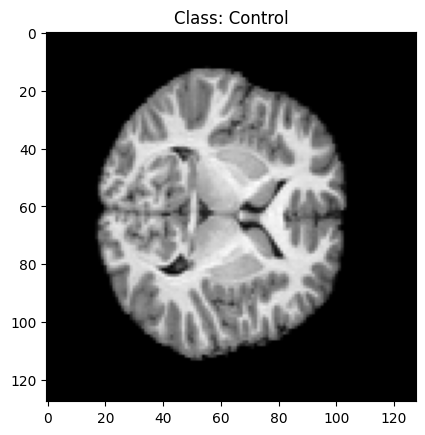

In [26]:
# Verify first batch
X, y = train_gen[0]
print(f"Batch shape: {X.shape}")
print(f"Labels: {y}")

# Visualize a sample
import matplotlib.pyplot as plt
plt.imshow(X[0,:,:,64,0], cmap='gray')  # Middle axial slice
plt.title(f"Class: {'ADHD' if y[0]==1 else 'Control'}")
plt.show()

In [27]:
import tensorflow as tf
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import Sequence
from scipy.ndimage import rotate, zoom

class AugmentedADHDDataGenerator(Sequence):
    def __init__(self, df, batch_size=8, dim=(128,128,128), shuffle=True, augment=True):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        X = np.empty((len(batch_df), *self.dim, 1))
        y = batch_df['DX'].values

        for i, path in enumerate(batch_df['mri_path']):
            try:
                img = nib.load(path).get_fdata()

                # Apply augmentation if enabled
                if self.augment:
                    img = self._augment_3d_image(img)

                # Normalize
                img = (img - img.mean()) / (img.std() + 1e-8)
                X[i,] = img[..., np.newaxis]

            except Exception as e:
                print(f"Error loading {path}: {str(e)}")
                X[i,] = np.zeros((*self.dim, 1))

        return X, y

    def _augment_3d_image(self, img):
        """Apply 3D augmentation techniques"""
        # Random rotation (0-15 degrees)
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-15, 15)
            img = rotate(img, angle, axes=(0,1), reshape=False, mode='nearest')

        # Random zoom (90-110%)
        if np.random.rand() > 0.5:
            zoom_factor = np.random.uniform(0.9, 1.1)
            img = zoom(img, zoom_factor, mode='nearest')
            # Crop back to original size if needed
            if zoom_factor < 1:
                pad = [(s - int(s * zoom_factor)) // 2 for s in img.shape]
                img = np.pad(img, [(p, p) for p in pad], mode='constant')
            else:
                center = [s // 2 for s in img.shape]
                img = img[
                    center[0]-self.dim[0]//2:center[0]+self.dim[0]//2,
                    center[1]-self.dim[1]//2:center[1]+self.dim[1]//2,
                    center[2]-self.dim[2]//2:center[2]+self.dim[2]//2
                ]

        # Random flip
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=np.random.choice([0,1,2]))

        # Random intensity shift
        if np.random.rand() > 0.5:
            img = img * np.random.uniform(0.9, 1.1)
            img = img + np.random.uniform(-0.1, 0.1)

        return img

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [28]:
# 1. First, create the simplest possible model to verify everything works
simple_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
    tf.keras.layers.Conv3D(8, 3, activation='relu'),
    tf.keras.layers.MaxPool3D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

simple_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# 2. Train for just 2 epochs to verify the pipeline
history = simple_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,  # Just 2 epochs to test
    verbose=1
)

# 3. Quick check
print("\nQuick test results:")
loss, acc = simple_model.evaluate(test_gen, verbose=0)
print(f"Test accuracy: {acc:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 223s 14s/step - accuracy: 0.7269 - loss: 34.6996 - val_accuracy: 0.9048 - val_loss: 14.3224
Epoch 2/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 216s 14s/step - accuracy: 0.8683 - loss: 17.5115 - val_accuracy: 0.9048 - val_loss: 3.2461

Quick test results:
Test accuracy: 0.86
